# Generate vehicle routing problem instance

In [1]:
import qiskit
print(qiskit.version.get_version_info())

2.1.1


In [2]:
import numpy as np

n = 4  # number of nodes + depot (n+1)
K = 2  # number of vehicles

# Get the data randomly placed nodes
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):
        n = self.n

        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2 
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance
    
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

In [3]:
print(instance)

[[ 0.         36.84023052  5.061353   30.63150414]
 [36.84023052  0.         24.55322904 63.21893593]
 [ 5.061353   24.55322904  0.         15.49719877]
 [30.63150414 63.21893593 15.49719877  0.        ]]


# Functions to convert problem to QUBO


In [4]:
# from qiskit_optimization.problems.quadratic_program import QuadraticProgram
import networkx as nx
import itertools
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.problems import QuadraticProgram


def vehicle_routing_to_quadratic_program(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    """
    Convert a vehicle routing problem instance into a QuadraticProgram.

    Args:
        graph: A networkx graph with edge weights representing distances or costs.
        depot: The index of the depot node.
        num_vehicles: The number of vehicles available.

    Returns:
        A QuadraticProgram representing the vehicle routing problem.
    """
    mdl = Model(name="Vehicle routing")
    n = graph.number_of_nodes()
    x = {}

    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")

    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            graph.edges[i, j]["weight"] * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )

    # Each node (except depot) has one outgoing and one incoming edge
    for i in range(n):
        if i != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for j in range(n) if i != j) == 1)
    for j in range(n):
        if j != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for i in range(n) if i != j) == 1)

    # Depot constraints: exactly num_vehicles enter and leave
    mdl.add_constraint(
        mdl.sum(x[i, depot] for i in range(n) if i != depot) == num_vehicles
    )
    mdl.add_constraint(
        mdl.sum(x[depot, j] for j in range(n) if j != depot) == num_vehicles
    )

    # Sub-tour elimination (using clique constraints)
    node_list = [i for i in range(n) if i != depot]
    for i in range(2, len(node_list) + 1):
        for clique in itertools.combinations(node_list, i):
            mdl.add_constraint(
                mdl.sum(x[i, j] for i in clique for j in clique if i != j) <= len(clique) - 1
            )

    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp


def vehicle_routing_to_objective(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    mdl = Model(name="Vehicle routing obj")
    n = graph.number_of_nodes()
    x = {}
    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")
    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            graph.edges[i, j]["weight"] * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )
    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp
    

# Constrained Linear Problem

In [5]:
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes and edges from the distance matrix
num_nodes = instance.shape[0]
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Avoid duplicate edges
        if instance[i, j] > 0:  # skip zero or invalid distances
            G.add_edge(i, j, weight=instance[i, j])

vrp3 = vehicle_routing_to_quadratic_program(G, depot=0, num_vehicles=K)

vrp_obj = vehicle_routing_to_objective(G, depot=0, num_vehicles=K)

print(vrp3.prettyprint())

Problem name: Vehicle routing

Minimize
  36.840230524848785*x_0_1 + 5.061352996006702*x_0_2 + 30.631504139776087*x_0_3
  + 36.840230524848785*x_1_0 + 24.553229038971544*x_1_2
  + 63.21893592648173*x_1_3 + 5.061352996006702*x_2_0 + 24.553229038971544*x_2_1
  + 15.497198766817078*x_2_3 + 30.631504139776087*x_3_0
  + 63.21893592648173*x_3_1 + 15.497198766817078*x_3_2

Subject to
  Linear constraints (12)
    x_1_0 + x_1_2 + x_1_3 == 1  'c0'
    x_2_0 + x_2_1 + x_2_3 == 1  'c1'
    x_3_0 + x_3_1 + x_3_2 == 1  'c2'
    x_0_1 + x_2_1 + x_3_1 == 1  'c3'
    x_0_2 + x_1_2 + x_3_2 == 1  'c4'
    x_0_3 + x_1_3 + x_2_3 == 1  'c5'
    x_1_0 + x_2_0 + x_3_0 == 2  'c6'
    x_0_1 + x_0_2 + x_0_3 == 2  'c7'
    x_1_2 + x_2_1 <= 1  'c8'
    x_1_3 + x_3_1 <= 1  'c9'
    x_2_3 + x_3_2 <= 1  'c10'
    x_1_2 + x_1_3 + x_2_1 + x_2_3 + x_3_1 + x_3_2 <= 2  'c11'

  Binary variables (12)
    x_0_1 x_0_2 x_0_3 x_1_0 x_1_2 x_1_3 x_2_0 x_2_1 x_2_3 x_3_0 x_3_1 x_3_2



## To QUBO

In [6]:
from qiskit_optimization.converters import QuadraticProgramToQubo

conv = QuadraticProgramToQubo(penalty=np.sum(instance)*2)    # ..............PENALTY...........
qubo_with_constraints = conv.convert(vrp3)
print(qubo_with_constraints.export_as_lp_string())

qubo_obj = conv.convert(vrp_obj)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Vehicle routing

Minimize
 obj: - 4182.418602904797 x_0_1 - 4214.197480433639 x_0_2
      - 4188.627329289870 x_0_3 - 4182.418602904797 x_1_0
      - 5601.125215533890 x_1_2 - 5562.459508646380 x_1_3
      - 4214.197480433639 x_2_0 - 5601.125215533890 x_2_1
      - 5610.181245806044 x_2_3 - 4188.627329289870 x_3_0
      - 5562.459508646380 x_3_1 - 5610.181245806044 x_3_2
      - 2812.839222286430 c11@int_slack@0 - 2812.839222286430 c11@int_slack@1 +
      [ 2812.839222286430 x_0_1^2 + 2812.839222286430 x_0_1*x_0_2
      + 2812.839222286430 x_0_1*x_0_3 + 2812.839222286430 x_0_1*x_2_1
      + 2812.839222286430 x_0_1*x_3_1 + 2812.839222286430 x_0_2^2
      + 2812.839222286430 x_0_2*x_0_3 + 2812.839222286430 x_0_2*x_1_2
      + 2812.839222286430 x_0_2*x_3_2 + 2812.839222286430 x_0_3^2
      + 2812.839222286430 x_0_3*x_1_3 + 2812.839222286430 x_0_3*x_2_3
      + 2812.839222286430 x_1_0^2 + 2812.839222286430 x_1_0

In [7]:
print(qubo_with_constraints._objective._linear.to_dict(), "\n")
print(qubo_with_constraints._objective._quadratic.to_dict())

{0: -4182.418602904797, 1: -4214.197480433639, 2: -4188.6273292898695, 3: -4182.418602904797, 4: -5601.12521553389, 5: -5562.45950864638, 6: -4214.197480433639, 7: -5601.12521553389, 8: -5610.181245806044, 9: -4188.6273292898695, 10: -5562.45950864638, 11: -5610.181245806044, 12: -2812.8392222864304, 13: -2812.8392222864304} 

{(0, 0): 1406.4196111432152, (0, 1): 1406.4196111432152, (0, 2): 1406.4196111432152, (0, 7): 1406.4196111432152, (0, 10): 1406.4196111432152, (1, 1): 1406.4196111432152, (1, 2): 1406.4196111432152, (1, 4): 1406.4196111432152, (1, 11): 1406.4196111432152, (2, 2): 1406.4196111432152, (2, 5): 1406.4196111432152, (2, 8): 1406.4196111432152, (3, 3): 1406.4196111432152, (3, 4): 1406.4196111432152, (3, 5): 1406.4196111432152, (3, 6): 1406.4196111432152, (3, 9): 1406.4196111432152, (4, 4): 2109.6294167148226, (4, 5): 2812.8392222864304, (4, 7): 2109.6294167148226, (4, 8): 1406.4196111432152, (4, 10): 1406.4196111432152, (4, 11): 2812.8392222864304, (4, 12): 1406.41961114

In [8]:
Q = qubo_with_constraints.objective.quadratic.to_array()

# Simplify diagonal terms: x^2 = x
linear = qubo_with_constraints.objective.linear.to_array()
diag = np.diag(Q)

# Update linear: x^2 term becomes x
simplified_linear = linear + diag

# Zero out the diagonal in the quadratic matrix
np.fill_diagonal(Q, 0)

# print simplified objective
print("Simplified linear:", simplified_linear)
print("Simplified quadratic (off-diagonal):\n", Q)

Simplified linear: [-2775.99899176 -2807.77786929 -2782.20771815 -2775.99899176
 -3491.49579882 -3452.83009193 -2807.77786929 -3491.49579882
 -3500.55182909 -2782.20771815 -3452.83009193 -3500.55182909
 -2109.62941671 -2109.62941671]
Simplified quadratic (off-diagonal):
 [[   0.         1406.41961114 1406.41961114    0.            0.
     0.            0.         1406.41961114    0.            0.
  1406.41961114    0.            0.            0.        ]
 [   0.            0.         1406.41961114    0.         1406.41961114
     0.            0.            0.            0.            0.
     0.         1406.41961114    0.            0.        ]
 [   0.            0.            0.            0.            0.
  1406.41961114    0.            0.         1406.41961114    0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.         1406.41961114
  1406.41961114 1406.41961114    0.            0.         1406.41961114
     0.        

In [9]:
def build_qubo_from_arrays(linear, quadratic, variable_names=None):
    n = len(linear)
    qp = QuadraticProgram()
    
    # If variable names are not given, create default names
    if variable_names is None:
        variable_names = [f'x{i}' for i in range(n)]
    
    # Add binary variables
    for name in variable_names:
        qp.binary_var(name._name)
    
    # Add objective: minimize linear + quadratic terms
    linear_dict = {variable_names[i]._name: linear[i] for i in range(n)}
    
    # Only use upper triangle of Q to avoid double-counting
    quadratic_dict = {}
    for i in range(n):
        for j in range(i + 1, n):
            if quadratic[i, j] != 0:
                quadratic_dict[(variable_names[i]._name, variable_names[j]._name)] = quadratic[i, j]

    max_lin_coeff = max(abs(v) for v in linear_dict.values())
    max_quad_coeff = max(abs(v) for v in quadratic_dict.values())

    if max_lin_coeff > max_quad_coeff:
        linear_dict_normed = {k: v / max_lin_coeff for k, v in linear_dict.items()}
        quadratic_dict_normed = {k: v / max_lin_coeff for k, v in quadratic_dict.items()}
    else:
        linear_dict_normed = {k: v / max_quad_coeff for k, v in linear_dict.items()}
        quadratic_dict_normed = {k: v / max_quad_coeff for k, v in quadratic_dict.items()}         
    
    qp.minimize(linear=linear_dict_normed, quadratic=quadratic_dict_normed)
    
    return qp

In [10]:
qubo_simple = build_qubo_from_arrays(simplified_linear, Q, variable_names=qubo_with_constraints.variables)
print(qubo_simple.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 0.793017537604 x_0_1 - 0.802095785572 x_0_2 - 0.794791179786 x_0_3
      - 0.793017537604 x_1_0 - 0.997412970665 x_1_2 - 0.986367367350 x_1_3
      - 0.802095785572 x_2_0 - 0.997412970665 x_2_1 - x_2_3
      - 0.794791179786 x_3_0 - 0.986367367350 x_3_1 - x_3_2
      - 0.602656243848 c11@int_slack@0 - 0.602656243848 c11@int_slack@1 + [
      0.803541658464 x_0_1*x_0_2 + 0.803541658464 x_0_1*x_0_3
      + 0.803541658464 x_0_1*x_2_1 + 0.803541658464 x_0_1*x_3_1
      + 0.803541658464 x_0_2*x_0_3 + 0.803541658464 x_0_2*x_1_2
      + 0.803541658464 x_0_2*x_3_2 + 0.803541658464 x_0_3*x_1_3
      + 0.803541658464 x_0_3*x_2_3 + 0.803541658464 x_1_0*x_1_2
      + 0.803541658464 x_1_0*x_1_3 + 0.803541658464 x_1_0*x_2_0
      + 0.803541658464 x_1_0*x_3_0 + 1.607083316928 x_1_2*x_1_3
      + 1.205312487696 x_1_2*x_2_1 + 0.803541658464 x_1_2*x_2_3
      + 0.803541658464 x_1_2*x_3_1 + 1.6070833169

In [11]:
num_variables = 0
for nam in qubo_with_constraints.variables:
    num_variables +=1
    print(nam._name)

x_0_1
x_0_2
x_0_3
x_1_0
x_1_2
x_1_3
x_2_0
x_2_1
x_2_3
x_3_0
x_3_1
x_3_2
c11@int_slack@0
c11@int_slack@1


In [12]:
def calculate_cost(candidate_bitstring, A, Q):
    if isinstance(candidate_bitstring, str):
        # Convert string to array of ints
        x = np.array([int(bit) for bit in candidate_bitstring])
    elif isinstance(candidate_bitstring, np.ndarray):
        x = candidate_bitstring
    elif isinstance(candidate_bitstring, list):
        # Handle list of strings or ints
        if all(isinstance(bit, str) for bit in candidate_bitstring):
            x = np.array([int(bit) for bit in candidate_bitstring])
        else:
            x = np.array(candidate_bitstring)
    else:
        raise TypeError("Unsupported bitstring type. Must be str, list, or np.ndarray.")

    return x @ Q @ x + A @ x

In [13]:
ising_H = qubo_simple.to_ising()[0]
print(ising_H)

SparsePauliOp(['IIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZI', 'IIIIIIIIIIIZII', 'IIIIIIIIIIZIII', 'IIIIIIIIIZIIII', 'IIIIIIIIZIIIII', 'IIIIIIIZIIIIII', 'IIIIIIZIIIIIII', 'IIIIIZIIIIIIII', 'IIIIZIIIIIIIII', 'IIIZIIIIIIIIII', 'IIZIIIIIIIIIII', 'IZIIIIIIIIIIII', 'ZIIIIIIIIIIIII', 'IIIIIIIIIIIIZZ', 'IIIIIIIIIIIZIZ', 'IIIIIIZIIIIIIZ', 'IIIZIIIIIIIIIZ', 'IIIIIIIIIIIZZI', 'IIIIIIIIIZIIZI', 'IIZIIIIIIIIIZI', 'IIIIIIIIZIIZII', 'IIIIIZIIIIIZII', 'IIIIIIIIIZZIII', 'IIIIIIIIZIZIII', 'IIIIIIIZIIZIII', 'IIIIZIIIIIZIII', 'IIIIIIIIZZIIII', 'IIIIIIZIIZIIII', 'IIIIIZIIIZIIII', 'IIIZIIIIIZIIII', 'IIZIIIIIIZIIII', 'IZIIIIIIIZIIII', 'ZIIIIIIIIZIIII', 'IIIIIIZIZIIIII', 'IIIIIZIIZIIIII', 'IIIZIIIIZIIIII', 'IIZIIIIIZIIIII', 'IZIIIIIIZIIIII', 'ZIIIIIIIZIIIII', 'IIIIIIZZIIIIII', 'IIIIIZIZIIIIII', 'IIIIZIIZIIIIII', 'IIIIIZZIIIIIII', 'IIIZIIZIIIIIII', 'IIZIIIZIIIIIII', 'IZIIIIZIIIIIII', 'ZIIIIIZIIIIIII', 'IIIZIZIIIIIIII', 'IIZIIZIIIIIIII', 'IZIIIZIIIIIIII', 'ZIIIIZIIIIIIII', 'IIIZZIIIIIIIII', 'IIZIZIIIIIIIII', 'IIZZIIIIIIII

In [14]:
print(ising_H.to_matrix(sparse=False))

[[ 0.60265624+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.19036129+0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.19943954+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  9.33972591+0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   9.33064766+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j 10.14471344+0.j]]


# Qiskit QAOA Ansatz to create parametrized circuit 

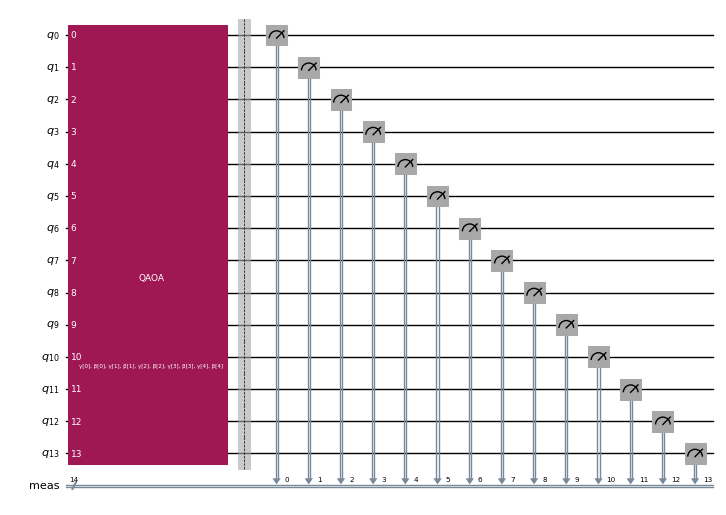

In [15]:
from qiskit.circuit.library import QAOAAnsatz, qaoa_ansatz

circuit = QAOAAnsatz(cost_operator=ising_H, reps=5)
circuit.measure_all()

circuit.draw('mpl', scale=0.5)

In [17]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4])])

# Transpile circuit

In [19]:
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(3, AerSimulator())

In [22]:
print(circuit.count_ops())

OrderedDict([('measure', 14), ('QAOA', 1), ('barrier', 1)])


In [23]:
isa_circuit = pass_manager.run(circuit)
print(isa_circuit.count_ops())

OrderedDict([('rzz', 230), ('rz', 70), ('rx', 70), ('h', 14), ('measure', 14), ('barrier', 1)])


# Initialize parameters and define cost estimator

In [24]:
# Linear ramp initialization
p = len(circuit.parameters)//2
d_B = 0.3
d_G = 0.6
lr_betas=np.zeros(p)
lr_gammas=np.zeros(p)
for i in range(p):
    lr_betas[i] = d_B*(1-i/p)
    lr_gammas[i] = d_G*(i+1)/p

In [25]:
initial_gamma = np.pi
initial_beta = np.pi/2
# init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

# init_params = [initial_gamma, initial_beta] * (len(circuit.parameters)//2)
init_params = [val for pair in zip(lr_gammas, lr_betas) for val in pair]
print(init_params)

# transform the observable defined on virtual qubits to observable defined on all physical qubits
isa_hamiltonian = ising_H.apply_layout(isa_circuit.layout)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    params_list.append(params)


    return cost

[0.12, 0.3, 0.24, 0.24, 0.36, 0.18, 0.48, 0.12, 0.6, 0.059999999999999984]


In [26]:
print(isa_hamiltonian)

SparsePauliOp(['IIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZI', 'IIIIIIIIIIIZII', 'IIIIIIIIIIZIII', 'IIIIIIIIIZIIII', 'IIIIIIIIZIIIII', 'IIIIIIIZIIIIII', 'IIIIIIZIIIIIII', 'IIIIIZIIIIIIII', 'IIIIZIIIIIIIII', 'IIIZIIIIIIIIII', 'IIZIIIIIIIIIII', 'IZIIIIIIIIIIII', 'ZIIIIIIIIIIIII', 'IIIIIIIIIIIIZZ', 'IIIIIIIIIIIZIZ', 'IIIIIIZIIIIIIZ', 'IIIZIIIIIIIIIZ', 'IIIIIIIIIIIZZI', 'IIIIIIIIIZIIZI', 'IIZIIIIIIIIIZI', 'IIIIIIIIZIIZII', 'IIIIIZIIIIIZII', 'IIIIIIIIIZZIII', 'IIIIIIIIZIZIII', 'IIIIIIIZIIZIII', 'IIIIZIIIIIZIII', 'IIIIIIIIZZIIII', 'IIIIIIZIIZIIII', 'IIIIIZIIIZIIII', 'IIIZIIIIIZIIII', 'IIZIIIIIIZIIII', 'IZIIIIIIIZIIII', 'ZIIIIIIIIZIIII', 'IIIIIIZIZIIIII', 'IIIIIZIIZIIIII', 'IIIZIIIIZIIIII', 'IIZIIIIIZIIIII', 'IZIIIIIIZIIIII', 'ZIIIIIIIZIIIII', 'IIIIIIZZIIIIII', 'IIIIIZIZIIIIII', 'IIIIZIIZIIIIII', 'IIIIIZZIIIIIII', 'IIIZIIZIIIIIII', 'IIZIIIZIIIIIII', 'IZIIIIZIIIIIII', 'ZIIIIIZIIIIIII', 'IIIZIZIIIIIIII', 'IIZIIZIIIIIIII', 'IZIIIZIIIIIIII', 'ZIIIIZIIIIIIII', 'IIIZZIIIIIIIII', 'IIZIZIIIIIIIII', 'IIZZIIIIIIII

## Run QAOA

In [27]:
%%time
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator

from scipy.optimize import minimize

objective_func_vals = [] # Global variable
params_list = []

estimator = Estimator()


def loss(x: np.ndarray) -> float:
    return cost_func_estimator(x, isa_circuit, isa_hamiltonian, estimator)


circuit.remove_final_measurements()
result = minimize(
    cost_func_estimator,
    init_params,
    args=(isa_circuit, isa_hamiltonian, estimator),
    method="COBYQA",
    tol=1e-2,
)
    
print(result)

 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: -1.8845303020634847
       x: [ 1.619e-01  6.838e-01  3.709e-01 -1.423e-01  1.711e+00
            1.812e-01  5.010e-01  2.517e-03  8.143e-01  3.875e-01]
     nit: 33
   maxcv: 0.0
    nfev: 78
CPU times: user 42min 13s, sys: 1.68 s, total: 42min 15s
Wall time: 1min 29s


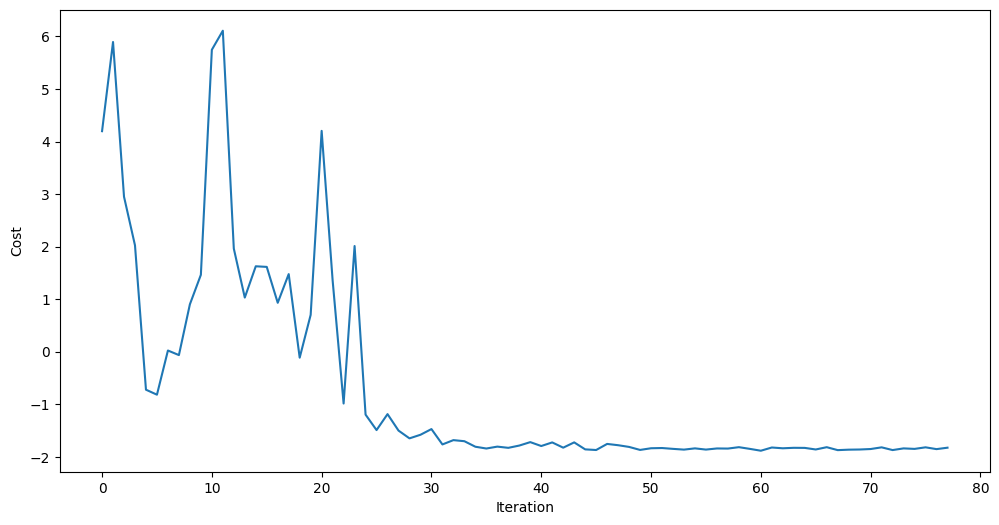

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [29]:
len(objective_func_vals)

78

In [30]:
print(params_list[-1])

[ 0.15914767  0.68075445  0.37188097 -0.13730633  1.71381769  0.18381079
  0.50030057  0.00588616  0.81799772  0.38384793]


In [31]:
optimized_circuit = isa_circuit.assign_parameters(params_list[-1])

optimized_circuit.measure_all()
# optimized_circuit.draw('mpl', fold=False, idle_wires=False)

# Run circuit with converged parameters

In [32]:
from qiskit_aer.primitives import SamplerV2 as Sampler

sampler = Sampler()


pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
# print(final_distribution_int)

In [33]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_variables)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


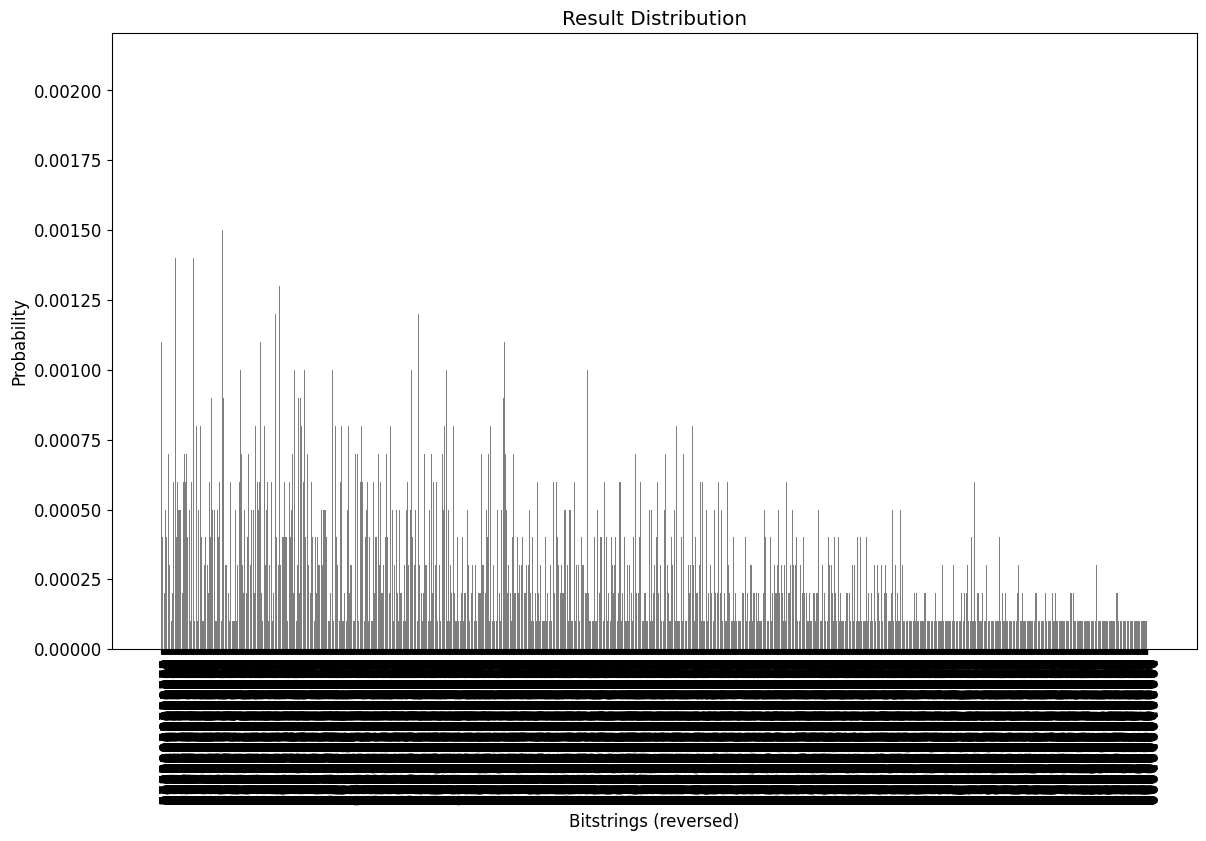

In [34]:
import matplotlib

matplotlib.rcParams.update({"font.size": 12})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
)
plt.show()

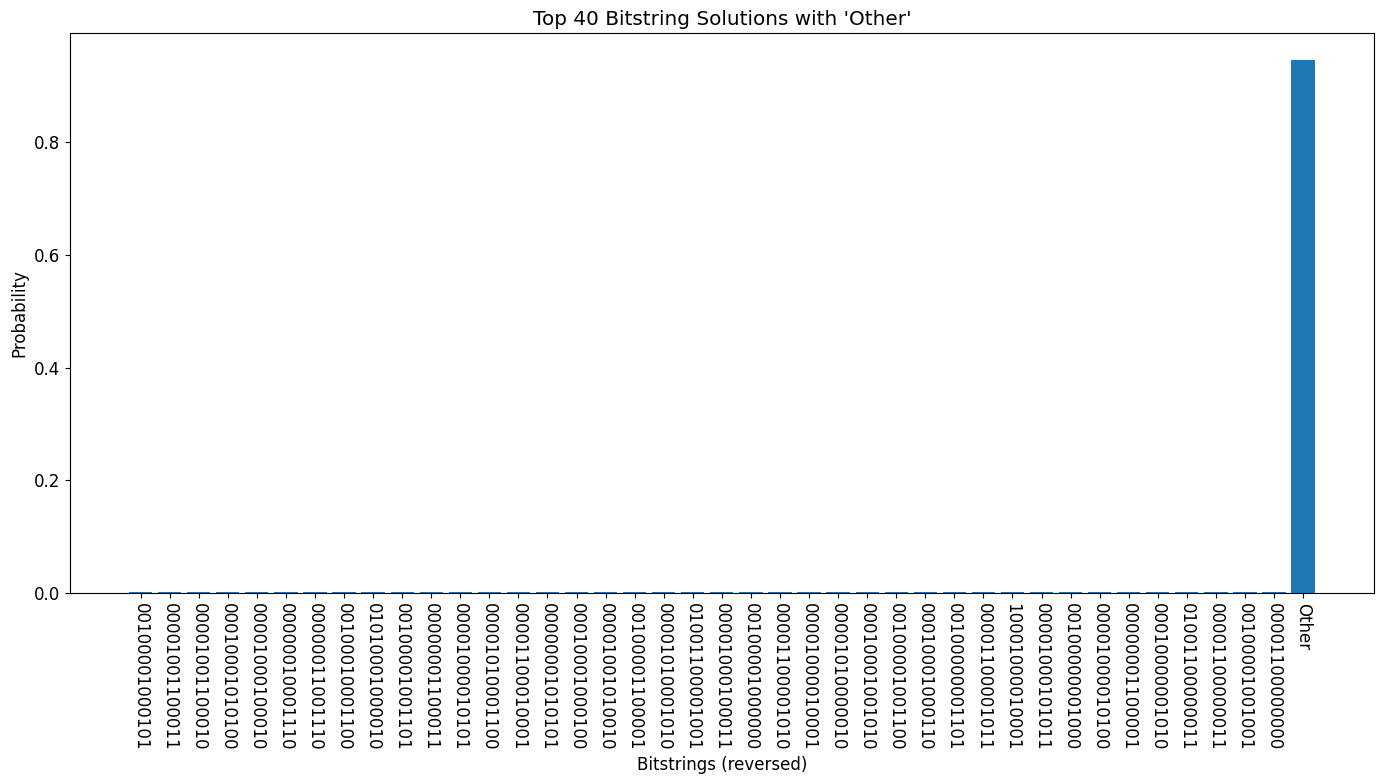

In [35]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Sort and extract top r values
r = 40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]
other_sum = sum(val for _, val in sorted_items[r:])

# Prepare labels and values
labels = [k for k, _ in top_r] + ["Other"]
values = [v for _, v in top_r] + [other_sum]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Bitstring Solutions with 'Other'")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

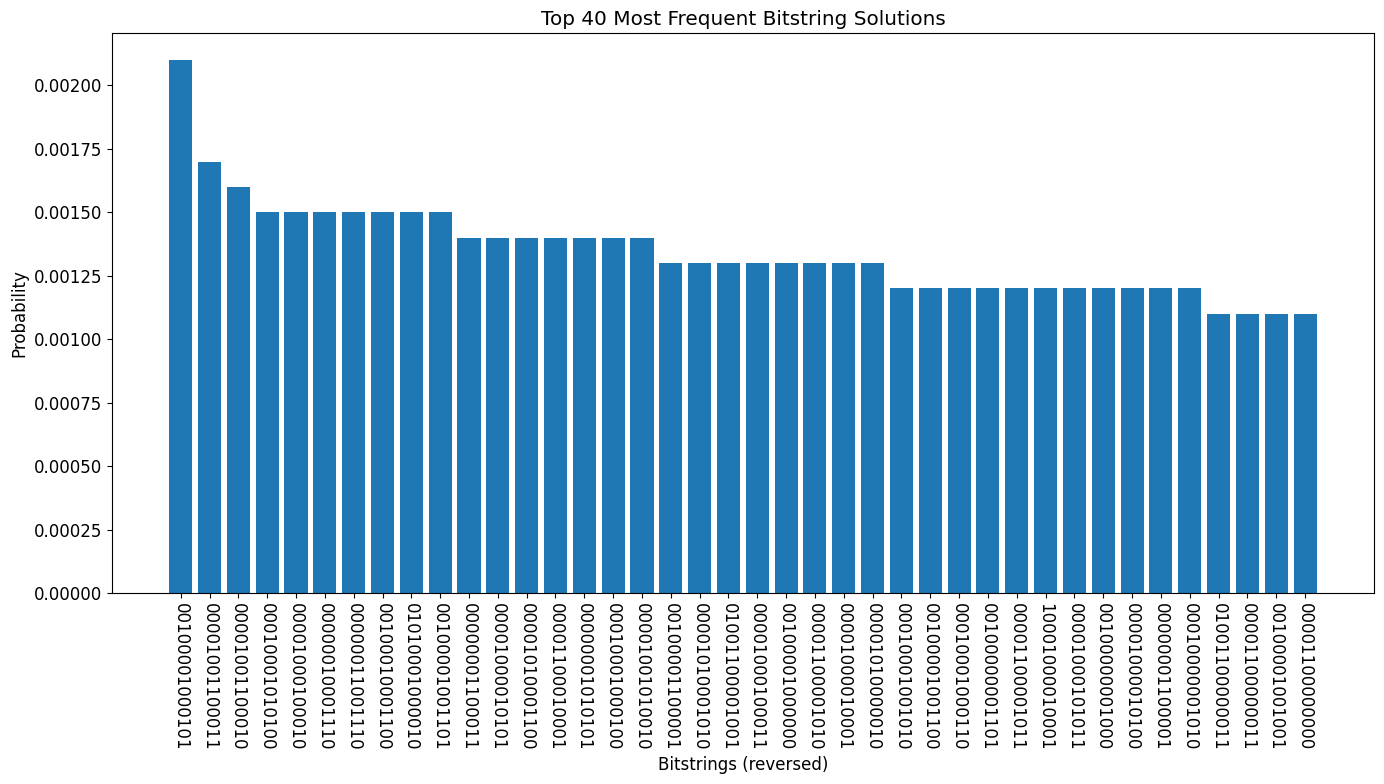

In [36]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Sort and get top r
r = 40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]

# Extract bitstrings and probabilities
labels = [k for k, _ in top_r]
values = [v for _, v in top_r]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Most Frequent Bitstring Solutions")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

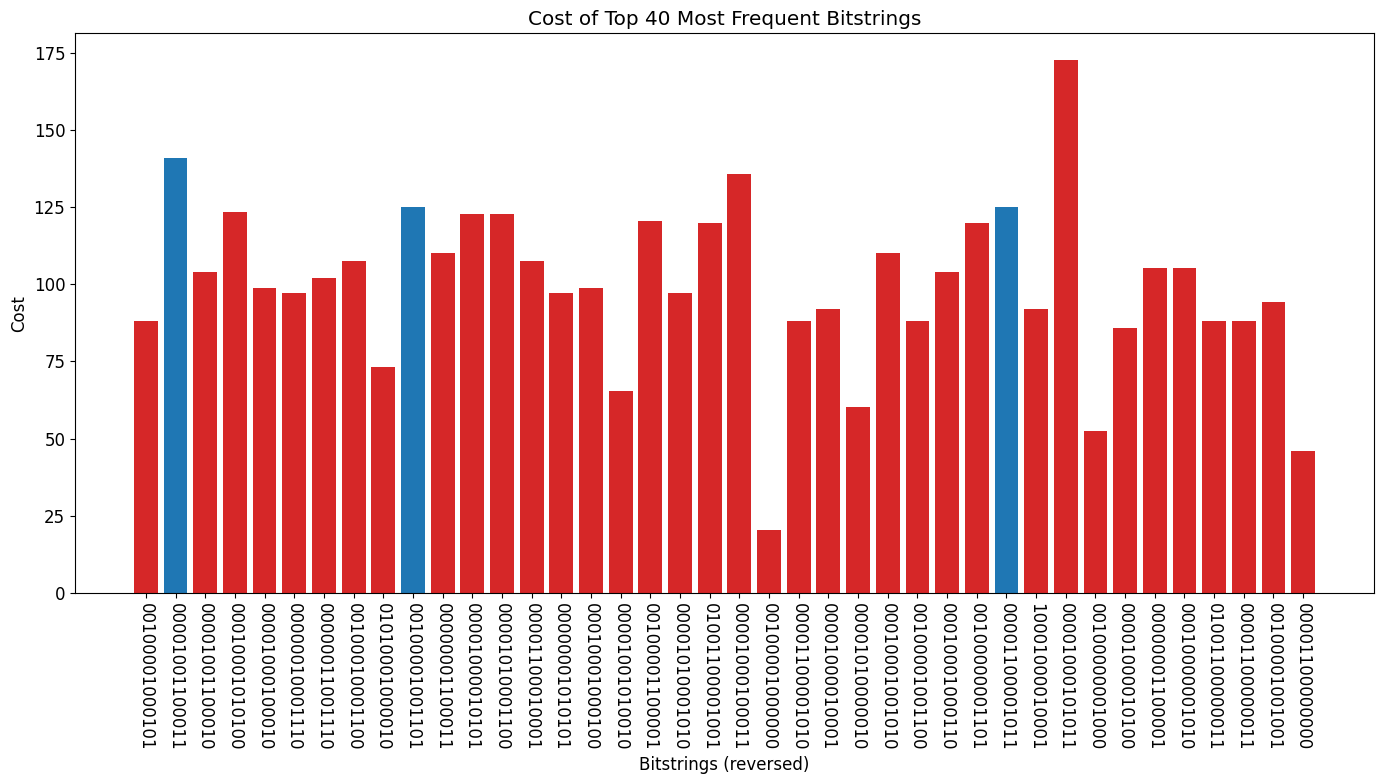

In [37]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

bitstrings = [k for k, _ in top_r]

costs =  []

feasible_flags = []
for bs in bitstrings:
    x = np.array([int(b) for b in bs[-12:][::-1]])  # convert string to binary array
    costs.append(vrp_obj.objective.evaluate(x))
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Cost of Top {r} Most Frequent Bitstrings")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Cost")

# Set bar colors based on feasibility
bar_colors = ["tab:blue" if f else "tab:red" for f in feasible_flags]
bars = ax.bar(bitstrings, costs, color=bar_colors)

plt.tight_layout()
plt.show()

## Plot the most frequent bit string

In [38]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    # plt.axis("equal")
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=9)

    plt.grid()

    for ii in range(0, len(x)):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.quiver(
                xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], 
                angles="xy", scale_units="xy", scale=1, color="b", width=0.005, headwidth=7, headlength=7)
    
    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

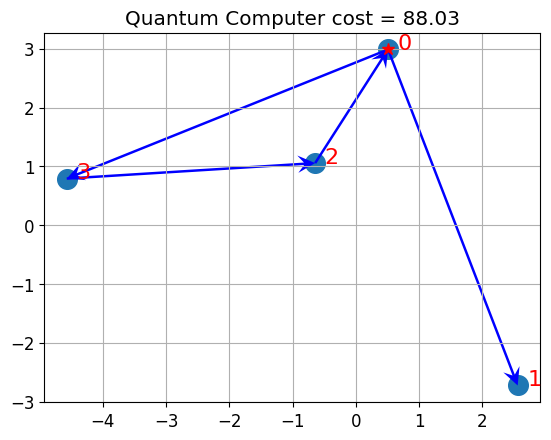

[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


In [39]:
# Put the solution in a way that is compatible with the classical variables
x_qc = np.zeros(n**2)
kk = 0
for ii in range(n**2):
    if ii // n != ii % n:
        x_qc[ii] = most_likely_bitstring[kk]
        kk += 1
  
qc_cost = vrp_obj.objective.evaluate([int(b) for b in most_likely_bitstring[:12]])
visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 
print(most_likely_bitstring)

## Plot the top 20 most sampled solutions


 [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]


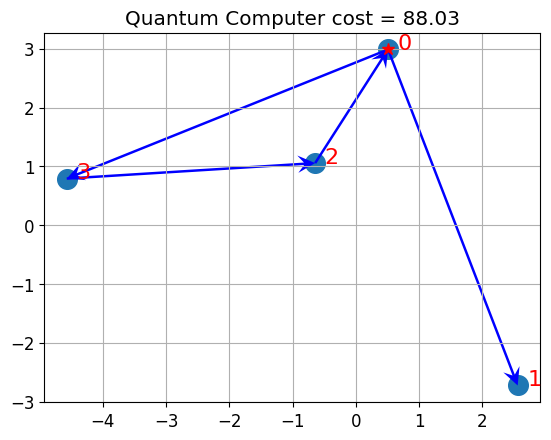


 [1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]


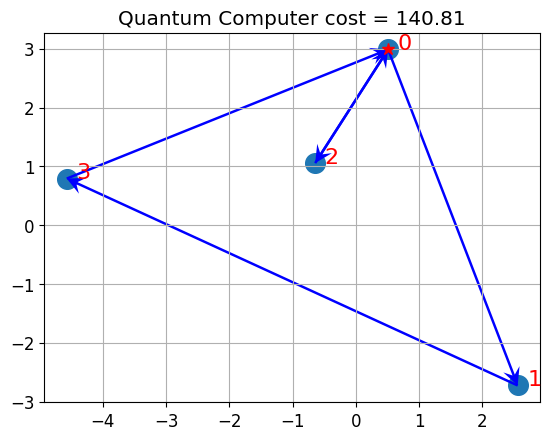


 [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]


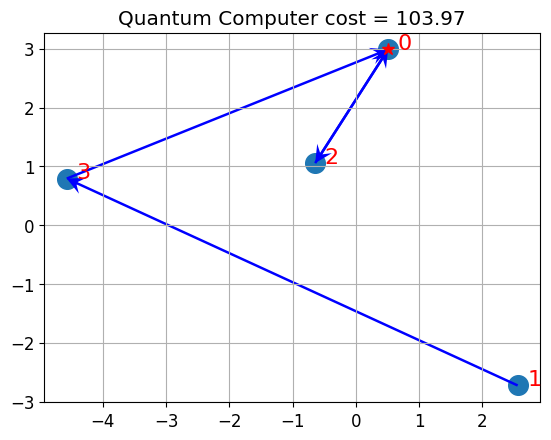


 [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]


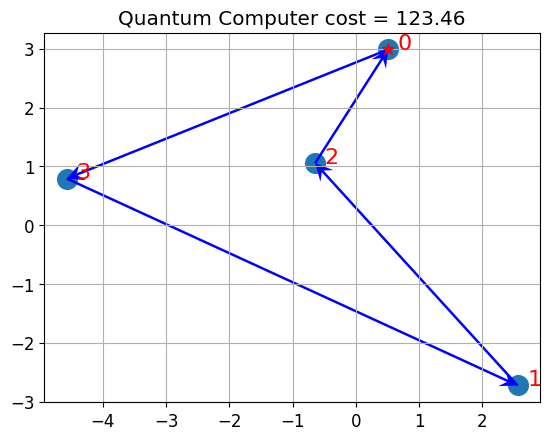


 [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


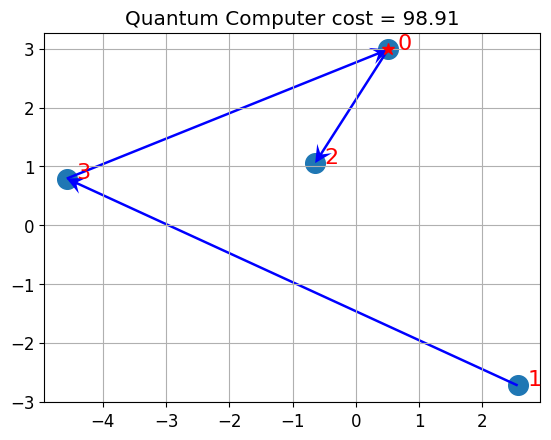


 [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]


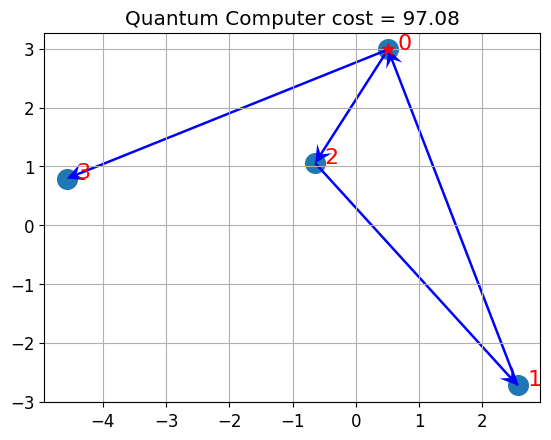


 [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]


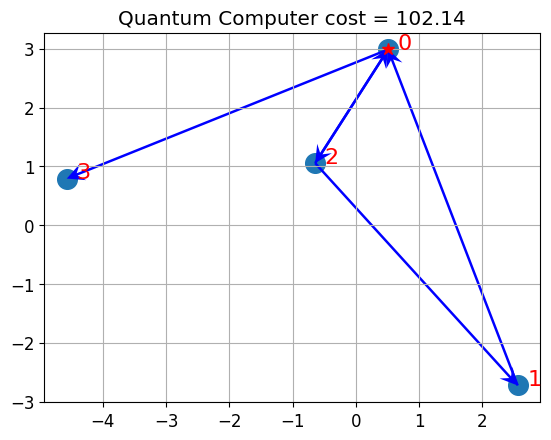


 [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]


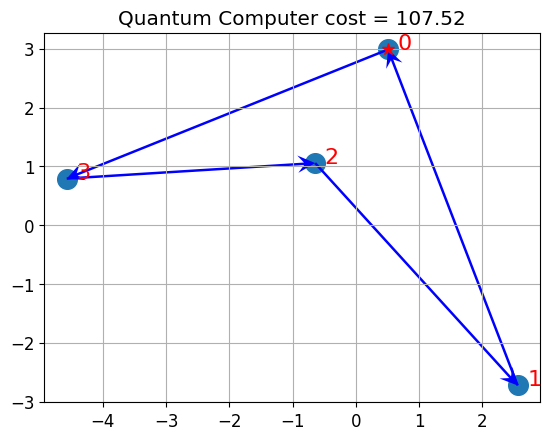


 [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]


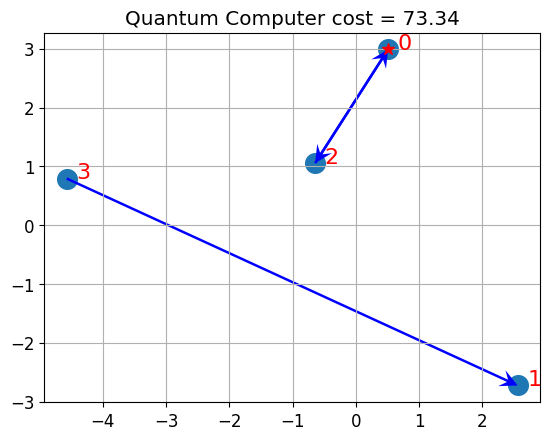


 [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1]


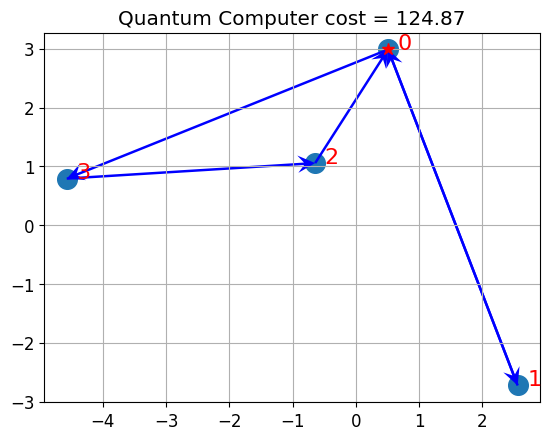


 [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


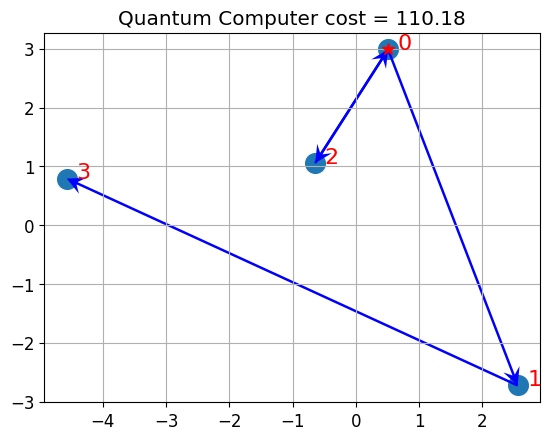


 [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]


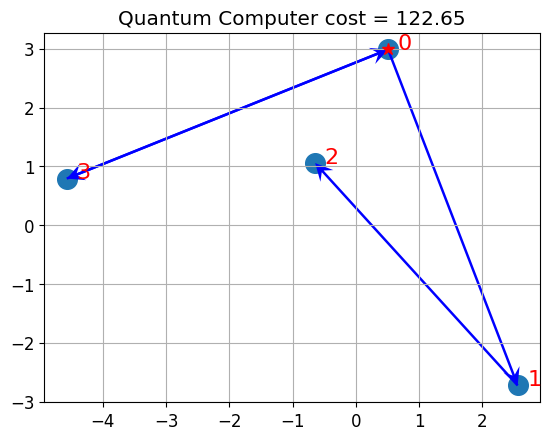


 [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]


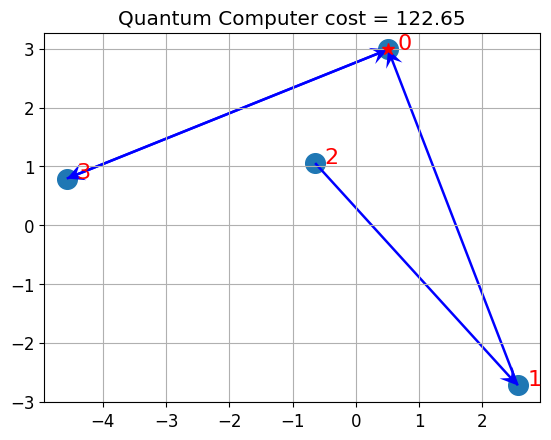


 [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


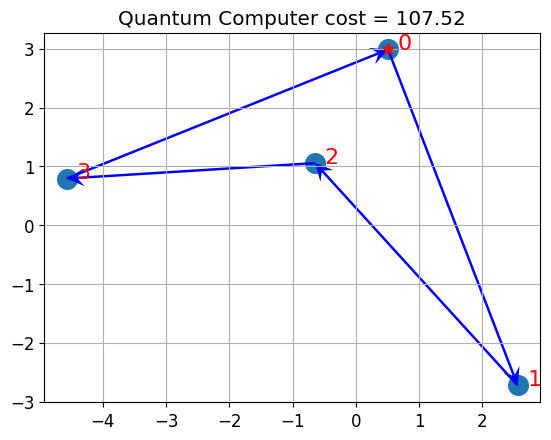


 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]


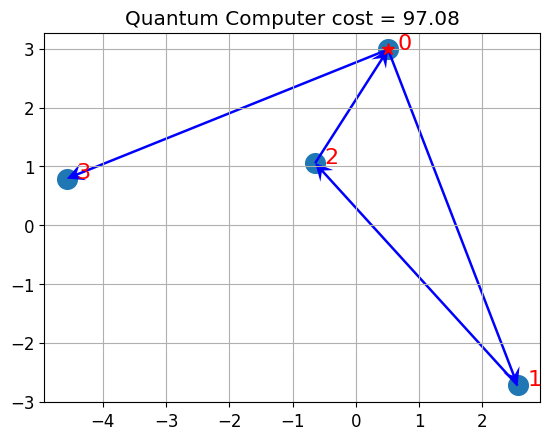


 [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]


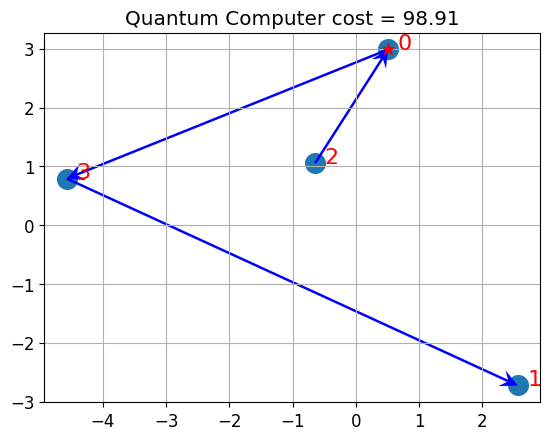


 [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]


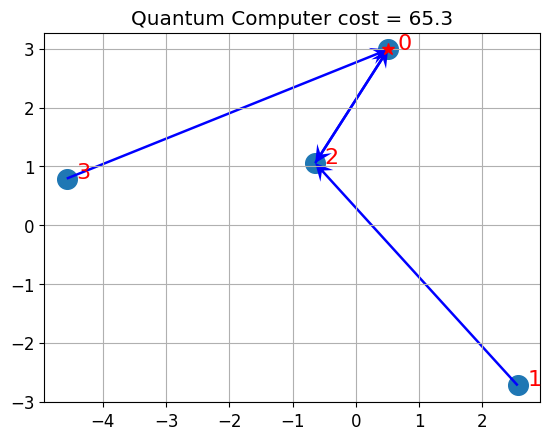


 [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]


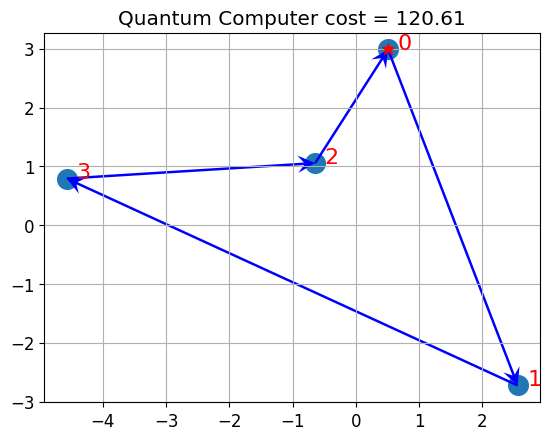


 [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]


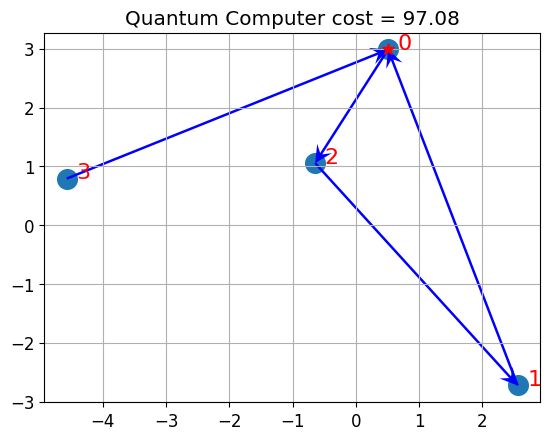


 [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]


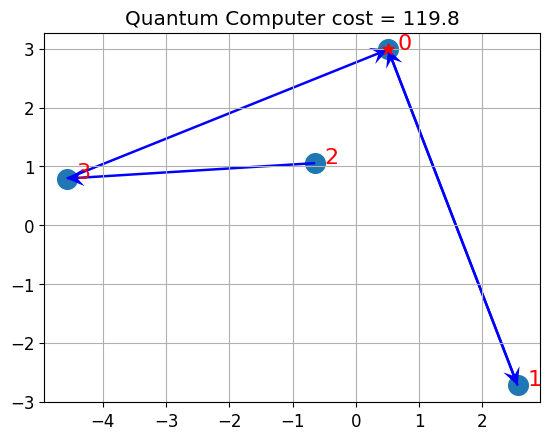

In [40]:
top_keys = bitstrings[:20]

for k in top_keys:
    m = [int(b) for b in k[-12:][::-1]]

    print("\n", m)
    x_qc = np.zeros(n**2)
    kk = 0
    for ii in range(n**2):
        if ii // n != ii % n:
            x_qc[ii] = m[kk]
            kk += 1

    qc_cost = vrp_obj.objective.evaluate([int(b) for b in m[:12]])
    visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 

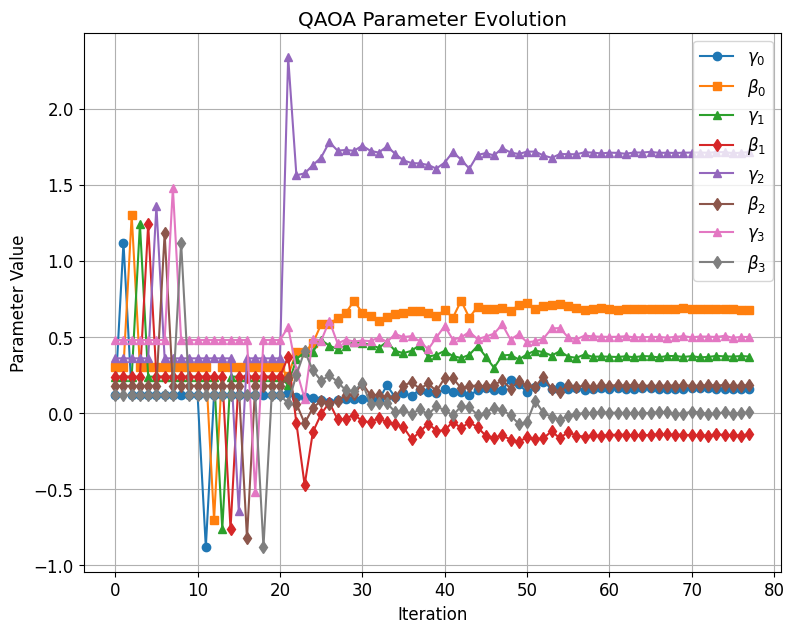

In [42]:
params_array = np.array(params_list)

# Extract each parameter series
iterations = np.arange(len(params_list))
gamma_0 = params_array[:, 0]
beta_0 = params_array[:, 1]
gamma_1 = params_array[:, 2]
beta_1 = params_array[:, 3]
gamma_2 = params_array[:, 4]
beta_2 = params_array[:, 5]
gamma_3 = params_array[:, 6]
beta_3 = params_array[:, 7]

# Plot all parameters
plt.figure(figsize=(9, 7))
plt.plot(iterations, gamma_0, marker='o', linestyle='-', label=r'$\gamma_0$')
plt.plot(iterations, beta_0, marker='s', linestyle='-', label=r'$\beta_0$')
plt.plot(iterations, gamma_1, marker='^', linestyle='-', label=r'$\gamma_1$')
plt.plot(iterations, beta_1, marker='d', linestyle='-', label=r'$\beta_1$')
plt.plot(iterations, gamma_2, marker='^', linestyle='-', label=r'$\gamma_2$')
plt.plot(iterations, beta_2, marker='d', linestyle='-', label=r'$\beta_2$')
plt.plot(iterations, gamma_3, marker='^', linestyle='-', label=r'$\gamma_3$')
plt.plot(iterations, beta_3, marker='d', linestyle='-', label=r'$\beta_3$')

# Labels and legend
plt.xlabel("Iteration")
plt.ylabel("Parameter Value")
plt.title("QAOA Parameter Evolution")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [43]:
M = 1000
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_M = sorted_items[:M]

bitstrings = [bs for bs, f in top_M]
freqs = [f for bs, f in top_M]

feasible_flags = []
feasible_freqs = []

for bs, f in top_M:
    # convert string to binary array (last 12 bits, reversed)
    x = np.array([int(b) for b in bs[-12:][::-1]])
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)
    if feasible:
        feasible_freqs.append(f)

# Count feasible bitstrings
feasible_count = sum(feasible_flags)
fraction_feasible = feasible_count / M

# Weighted fraction by frequencies
total_freq = sum(freqs)
feasible_freq_sum = sum(feasible_freqs)
fraction_feasible_weighted = feasible_freq_sum / total_freq

print(f"Feasible (count): {feasible_count}/{M}")
print(f"Fraction feasible (count): {fraction_feasible:.2%}")
print(f"Fraction feasible (weighted by frequency): {fraction_feasible_weighted:.2%}")


Feasible (count): 19/1000
Fraction feasible (count): 1.90%
Fraction feasible (weighted by frequency): 2.64%
